## This notebook implements the MIMO method on the University of Houston RGB and Hyperspectral images

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import math
import os
from spectral import *
from tqdm import tqdm
from argparse import Namespace
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf
from pdb import set_trace as stx
import numbers
from einops import rearrange

import torch
import torch.fft
from torchvision.models import ResNet
from torch.nn import PixelUnshuffle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import torchsummary
import torchprofile

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Defining the Gaussian PSF for synthetic data generation

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

In [4]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [5]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

In [6]:
# Function to visualize an HSI
def visualize_hsi_single(img1, bands, title1):
    """
    Visualize a hyperspectral image using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation
    title1 : str
        Title for the first image.
    """
    rgb1 = get_rgb(img1, bands)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.imshow(rgb1)
    ax.set_title(title1)
    ax.axis('on')

    plt.tight_layout()
    plt.show()
    
# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image, bands, title, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image : np.ndarray
        Multispectral image, shape: (rows, cols, num_bands).
    bands : tuple
        Band indices to use for RGB representation (only used if num_bands >= 3).
    title : str
        Title for the image plot.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands (x-axis for SRF).
    ikonos_bands : np.ndarray
        An array with shape (num_bands, 3) containing [center_nm, low_edge_nm, high_edge_nm]
        for each band. It is used here just to show the center wavelength in the legend.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image.shape[2]  # e.g. 1,3,4,8,16

    # 1) Choose band labels & colors depending on how many bands we have
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        # You can pick any 8 distinct colors you like:
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        # Again, pick any 16 distinct colors you like:
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")
    
    # 2) Create the figure with 2 subplots (image on the left, SRF on the right)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3) Plot the image
    if num_bands == 1:
        # Just display the single-band image in grayscale
        single_band_2d = ms_image[:, :, 0]  # shape (rows, cols)
        axs[0].imshow(single_band_2d, cmap="gray")
        axs[0].set_title(title + " (Single-Band/Panchromatic)")
    else:
        # We have at least 3 bands, so let's form an RGB image
        img_rgb = get_rgb(ms_image, bands)
        axs[0].imshow(img_rgb)
        axs[0].set_title(title)
    axs[0].axis('off')
    
    # 4) Plot the SRF curves in the second subplot
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]  # The 'center' column from your band_specs
        axs[1].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Spectral Response')
    axs[1].set_title('Spectral Response Functions (SRF)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Importing the University of Houston images

In [7]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Real_world_Fusion_based_HSI_Super_Resolution_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
hsi_1_file_path = os.path.join(normalized_dataset_path, 'hsi_1.mat')
hsi_2_file_path = os.path.join(normalized_dataset_path, 'hsi_2.mat')
rgb_1_file_path = os.path.join(normalized_dataset_path, 'rgb_image_1.tif')
rgb_2_file_path = os.path.join(normalized_dataset_path, 'rgb_image_2.tif')

In [8]:
def extract_aligned_patches(lr_hsi, hr_rgb, hsi_center_y, hsi_center_x,
                            hsi_patch_size=64, rgb_scale_factor=20, rgb_downsampled_size=512):
    """
    Extract a 64x64 patch from the LR HSI centered at (hsi_center_y, hsi_center_x),
    and the corresponding 1280x1280 patch from the HR RGB image centered at the
    scaled coordinates. Then downsample the RGB patch to 512x512.

    Parameters:
    -----------
    lr_hsi : np.ndarray
        Low-resolution HSI image of shape (H_lr, W_lr, C_hsi).
    hr_rgb : np.ndarray
        High-resolution RGB image of shape (H_hr, W_hr, 3).
    hsi_center_y : int
        Y-coordinate of the HSI patch center.
    hsi_center_x : int
        X-coordinate of the HSI patch center.
    hsi_patch_size : int
        Patch size for the HSI (default: 64).
    rgb_scale_factor : int
        Scaling factor between HSI and RGB resolutions (default: 20).
    rgb_downsampled_size : int
        Final size of the RGB patch after downsampling (default: 512).

    Returns:
    --------
    hsi_patch : np.ndarray
        Extracted HSI patch of shape (hsi_patch_size, hsi_patch_size, C_hsi).
    rgb_patch_downsampled : np.ndarray
        Downsampled RGB patch of shape (rgb_downsampled_size, rgb_downsampled_size, 3).
    """
    
    # --- HSI patch extraction ---
    half_hsi = hsi_patch_size // 2
    hsi_top = hsi_center_y - half_hsi
    hsi_left = hsi_center_x - half_hsi

    if (hsi_top < 0 or hsi_left < 0 or 
        hsi_top + hsi_patch_size > lr_hsi.shape[0] or 
        hsi_left + hsi_patch_size > lr_hsi.shape[1]):
        raise ValueError("HSI patch goes out of bounds.")

    hsi_patch = lr_hsi[
        hsi_top : hsi_top + hsi_patch_size,
        hsi_left : hsi_left + hsi_patch_size,
        :
    ]

    # --- RGB patch extraction ---
    rgb_patch_size = hsi_patch_size * rgb_scale_factor
    half_rgb = rgb_patch_size // 2
    rgb_center_y = hsi_center_y * rgb_scale_factor
    rgb_center_x = hsi_center_x * rgb_scale_factor
    rgb_top = rgb_center_y - half_rgb
    rgb_left = rgb_center_x - half_rgb

    if (rgb_top < 0 or rgb_left < 0 or 
        rgb_top + rgb_patch_size > hr_rgb.shape[0] or 
        rgb_left + rgb_patch_size > hr_rgb.shape[1]):
        raise ValueError("RGB patch goes out of bounds.")

    rgb_patch = hr_rgb[
        rgb_top : rgb_top + rgb_patch_size,
        rgb_left : rgb_left + rgb_patch_size,
        :
    ]

    # --- Downsample the RGB patch ---
    rgb_patch_downsampled = cv2.resize(
        rgb_patch,
        (rgb_downsampled_size, rgb_downsampled_size),
        interpolation=cv2.INTER_AREA
    )

    return hsi_patch, rgb_patch_downsampled

In [9]:
hsi_1 = sio.loadmat(hsi_1_file_path)
hsi_1_image = hsi_1['topLeft']

# Load image
RGB_1 = cv2.imread(rgb_1_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_1_image = np.array(RGB_1)

hsi_patch_1, rgb_patch_1 = extract_aligned_patches(
    lr_hsi=hsi_1_image,
    hr_rgb=RGB_1_image,
    hsi_center_y=400,
    hsi_center_x=450
)

hsi_1_test = normalize(hsi_patch_1)
RGB_1_test = normalize(rgb_patch_1)

In [10]:
hsi_2 = sio.loadmat(hsi_2_file_path)
hsi_2_image = hsi_2['bottomRight']

# Load image
RGB_2 = cv2.imread(rgb_2_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_2_image = np.array(RGB_2)

hsi_patch_2, rgb_patch_2 = extract_aligned_patches(
    lr_hsi=hsi_2_image,
    hr_rgb=RGB_2_image,
    hsi_center_y=400,
    hsi_center_x=400
)

hsi_2_test = normalize(hsi_patch_2)
RGB_2_test = normalize(rgb_patch_2)

Establishing training and inference images for the super resolution method

In [11]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

In [12]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'Pavia_center_data.mat')

In [13]:
def plot_alignment_grid_np(lr_hsi, hr_msi, hr_hsi, band_lr=25, band_hr=25, num_samples=3):
    """
    Visualize 10 random patches from NumPy arrays returned by make_patches.
    
    Args:
        lr_hsi: (N, 50, 64, 64) - low-res HSI
        hr_msi: (N, 3, 512, 512) - RGB
        hr_hsi: (N, 50, 512, 512) - high-res HSI GT
    """
    indices = np.random.choice(len(lr_hsi), size=num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))

    for i, idx in enumerate(indices):
        lr = np.transpose(lr_hsi[idx], (1, 2, 0))   # (64, 64, 50)
        msi = np.transpose(hr_msi[idx], (1, 2, 0))  # (512, 512, 3)
        hr = np.transpose(hr_hsi[idx], (1, 2, 0))   # (512, 512, 50)

        axs[i, 0].imshow(lr[:, :, band_lr], cmap='gray')
        axs[i, 0].set_title(f"LR HSI (band {band_lr})")

        axs[i, 1].imshow(msi / msi.max())
        axs[i, 1].set_title("HR RGB (MSI)")

        axs[i, 2].imshow(hr[:, :, band_hr], cmap='gray')
        axs[i, 2].set_title(f"GT HR HSI (band {band_hr})")

        for j in range(3):
            axs[i, j].axis('off')

    plt.tight_layout()
    fig.suptitle("Patch Alignment Check: LR HSI, HR MSI, HR HSI", fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

Ground truth image shape:  (1096, 712, 50)


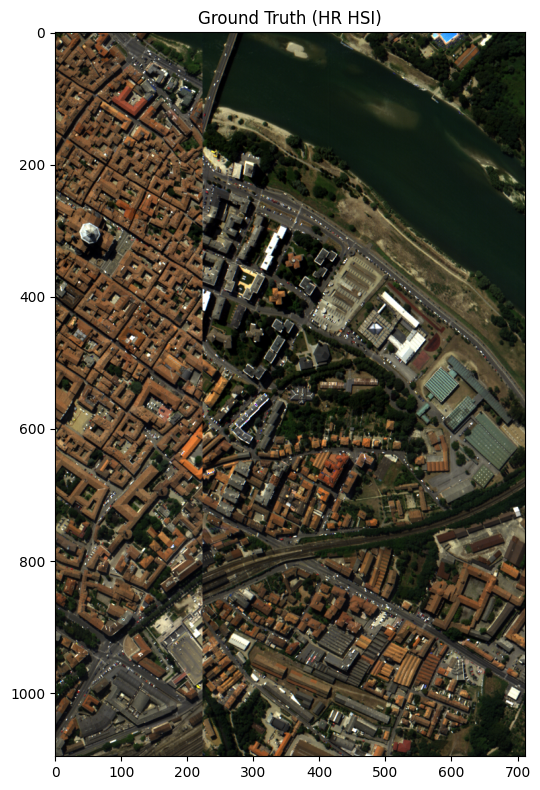

MSI shape:  (1096, 712, 3)


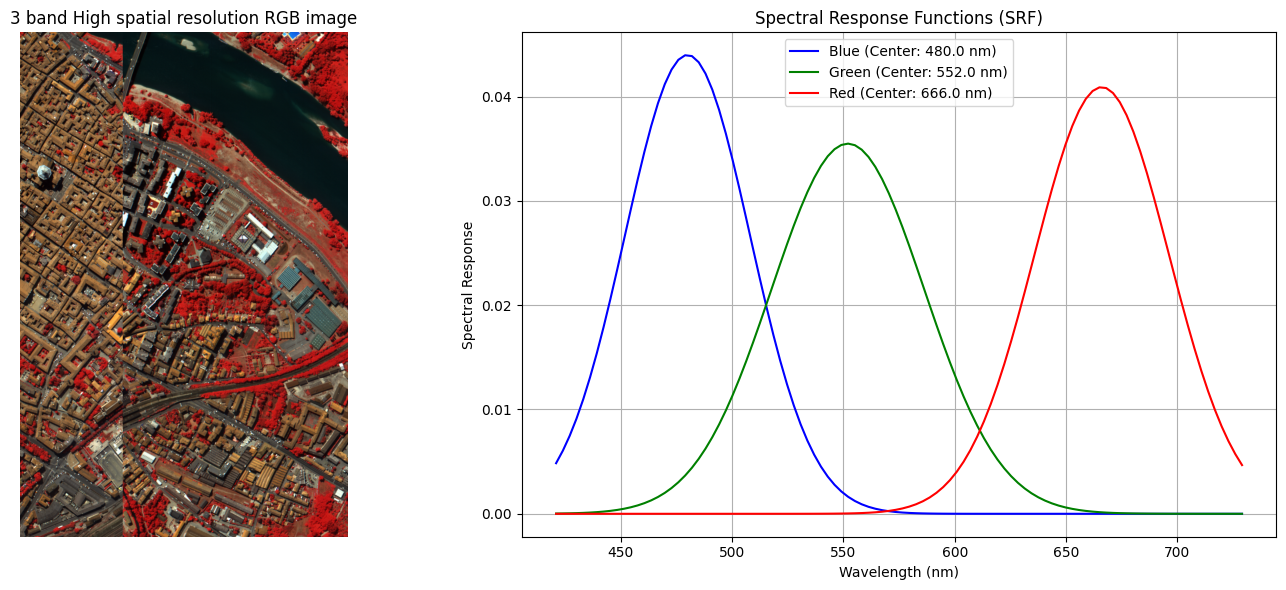

HSI shape with 8x Downsample:  (137, 89, 50)


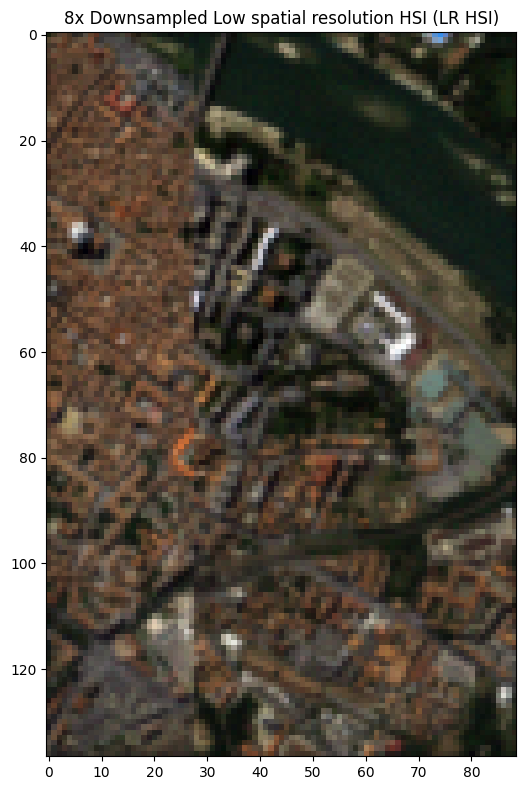

In [14]:
pavia_center = sio.loadmat(mat_file_path)
pavia_center_image = pavia_center['pavia']
pavia_center_image = pavia_center_image[:, :712, :]

# Select 50 uniformly spaced bands
selected_band_idxs = np.linspace(0, 101, 50, dtype=int)

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(pavia_center_image)
# Downsampling spectrally from 102 to 50 bands to make the training as close as possible to inference
I_REF = I_REF[:, :, selected_band_idxs]
print("Ground truth image shape: ", I_REF.shape)
visualize_hsi_single(I_REF, (25,17,7), "Ground Truth (HR HSI)")

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=pavia_center_image, SNR=40, num_bands=3, fwhm_factor=4.2)
print("MSI shape: ", I_MS_3.shape)
plot_multispectral_with_srf(I_MS_3, (2,1,0), "3 band High spatial resolution RGB image", srf_3, auto_wavs_3, band_specs_3)

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(pavia_center_image, gaus_psf, 8, 30)
# Downsampling spectrally from 102 to 50 bands to make the training as close as possible to inference
I_HS_8_gaus = I_HS_8_gaus[:, :, selected_band_idxs]
print("HSI shape with 8x Downsample: ", I_HS_8_gaus.shape)
visualize_hsi_single(I_HS_8_gaus, (25,17,7), "8x Downsampled Low spatial resolution HSI (LR HSI)")

UH Hyperspectral image 1 inference shape:  (64, 64, 50)
UH Hyperspectral image 2 inference shape:  (64, 64, 50)


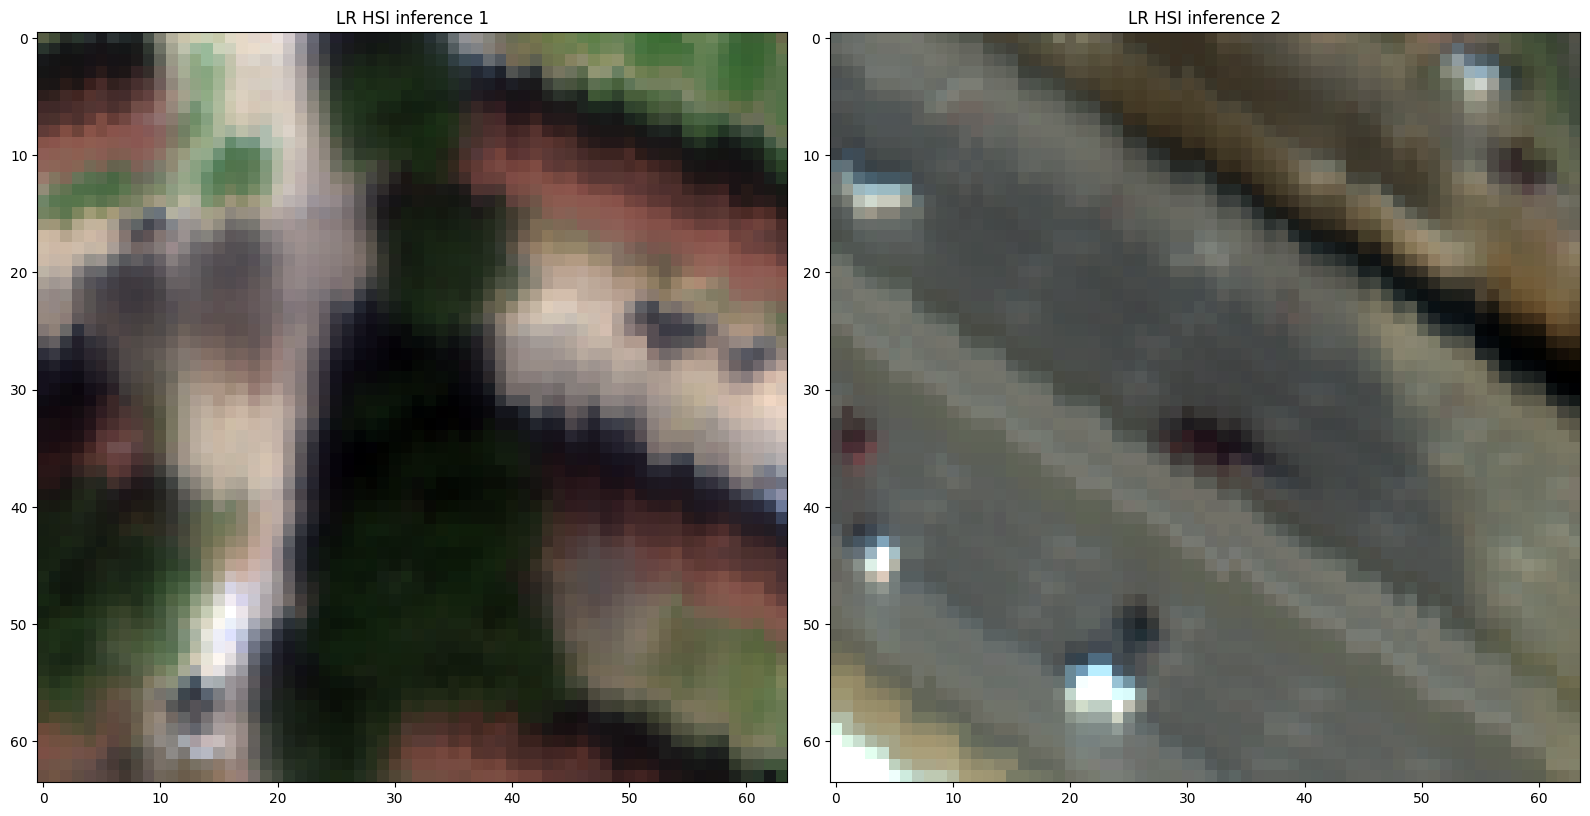

In [15]:
LR_HSI_test_1 = hsi_1_test
print("UH Hyperspectral image 1 inference shape: ", LR_HSI_test_1.shape)

LR_HSI_test_2 = hsi_2_test
print("UH Hyperspectral image 2 inference shape: ", LR_HSI_test_2.shape)

visualize_hsi(LR_HSI_test_1, LR_HSI_test_2, (20,13,8), "LR HSI inference 1", "LR HSI inference 2")

UH RGB image 1 inference shape:  (512, 512, 3)
UH RGB image 2 inference shape:  (512, 512, 3)


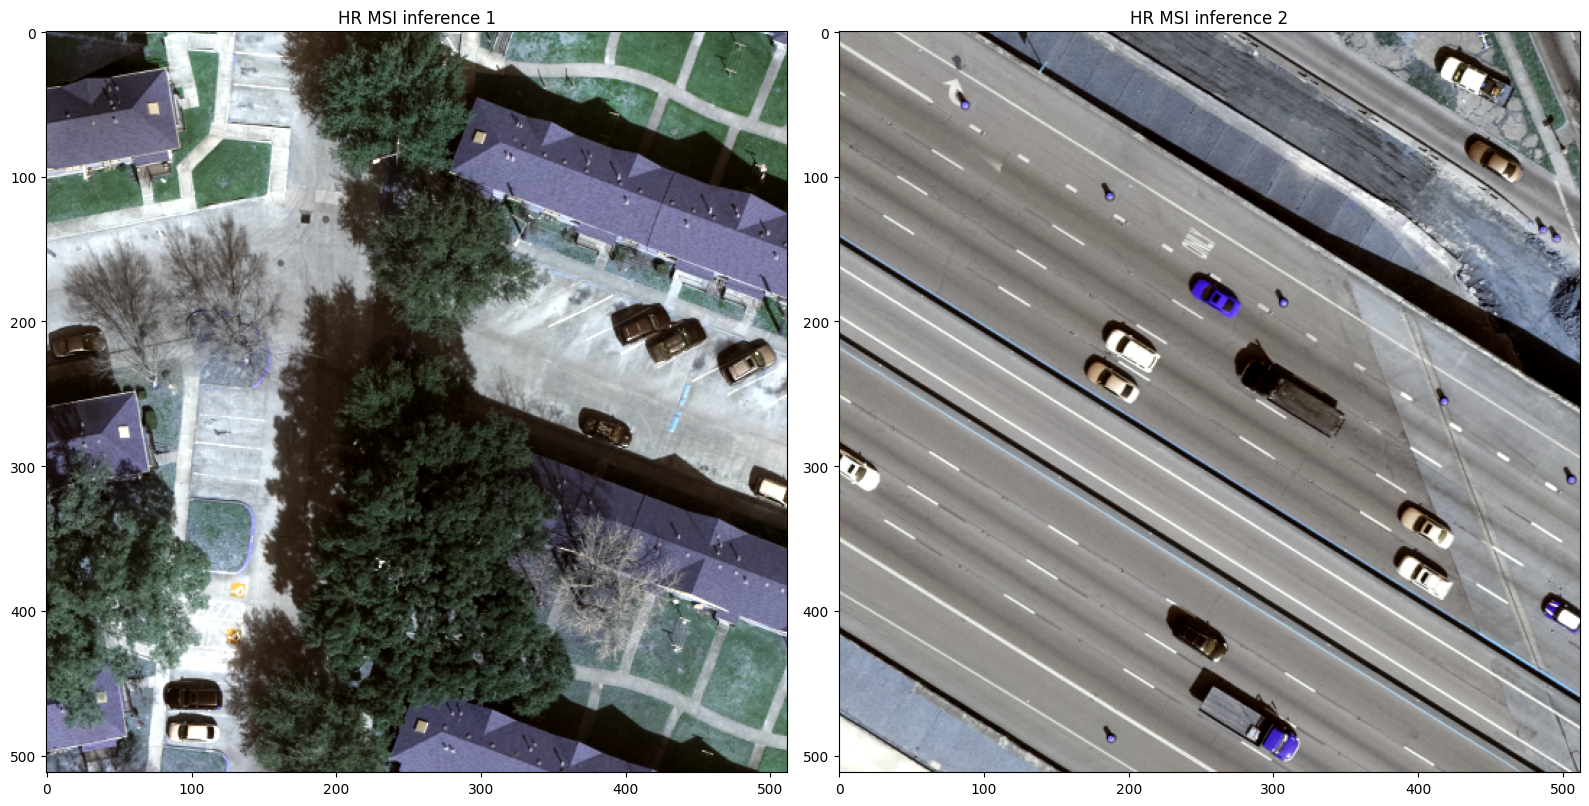

In [16]:
HR_MSI_test_1 = RGB_1_test
print("UH RGB image 1 inference shape: ", HR_MSI_test_1.shape)

HR_MSI_test_2 = RGB_2_test
print("UH RGB image 2 inference shape: ", HR_MSI_test_2.shape)

visualize_hsi(HR_MSI_test_1, HR_MSI_test_2, (0,1,2), "HR MSI inference 1", "HR MSI inference 2")

MIMO-SST: Multi-Input Multi-Output Spatial-Spectral Transformer for Hyperspectral and Multispectral Image Fusion implementation from their GitHub

In [17]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [18]:
def make_patches(hr_hsi, hr_msi, lr_hsi,
                 patch_hr=32, scale=8, stride_hr=256):
    """
    hr_hsi : (H,W,C_hsi)
    hr_msi : (H,W,C_msi)  # same spatial size as hr_hsi
    lr_hsi : (H/scale,W/scale,C_hsi)

    Returns three numpy arrays in (N,C,H,W) order.
    """
    stride_hr = stride_hr                 # non-overlapping patches
    stride_lr = stride_hr // scale

    def extract(img, p, s):
        H,W,C = img.shape
        out = []
        for y in range(0, H-p+1, s):
            for x in range(0, W-p+1, s):
                out.append(img[y:y+p, x:x+p, :])
        return np.stack(out)

    HR_HSI = extract(hr_hsi, patch_hr, stride_hr).transpose(0,3,1,2)
    HR_MSI = extract(hr_msi, patch_hr, stride_hr).transpose(0,3,1,2)
    LR_HSI = extract(lr_hsi, patch_hr//scale, stride_lr).transpose(0,3,1,2)

    return HR_MSI.astype(np.float32), LR_HSI.astype(np.float32), HR_HSI.astype(np.float32)


class PatchDS(torch.utils.data.Dataset):
    def __init__(self, msi, lr, gt):
        self.msi, self.lr, self.gt = map(torch.tensor, (msi, lr, gt))
    def __len__(self):  return self.msi.size(0)
    def __getitem__(self, i):  return (self.msi[i], self.lr[i], self.gt[i])

In [19]:
# ---------------------------------------------------------------------------
#  small util: inverse of nn.PixelShuffle (compatible with old PyTorch)
# ---------------------------------------------------------------------------

def pixel_unshuffle(x: torch.Tensor, r: int) -> torch.Tensor:
    """Downsamples (B,C,H,W) by factor *r* using standard pixel‑unshuffle."""
    if hasattr(F, "pixel_unshuffle"):
        return F.pixel_unshuffle(x, r)
    b, c, h, w = x.shape
    assert h % r == 0 and w % r == 0, "H and W must be divisible by r"
    x = x.view(b, c, h // r, r, w // r, r)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    return x.view(b, c * r * r, h // r, w // r)

# ---------------------------------------------------------------------------
#  Helpers: reshape, (Bias‑)Free LayerNorm                                    
# ---------------------------------------------------------------------------

def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x, h, w):
    return rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super().__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        self.weight = nn.Parameter(torch.ones(normalized_shape))

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma + 1e-5) * self.weight

class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super().__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias   = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        mu    = x.mean(-1, keepdim=True)
        sigma = x.var (-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma + 1e-5) * self.weight + self.bias

class LayerNorm(nn.Module):
    def __init__(self, dim, layer_type: str = 'WithBias'):
        super().__init__()
        self.body = BiasFree_LayerNorm(dim) if layer_type == 'BiasFree' else WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)

# ---------------------------------------------------------------------------
#  ECA block
# ---------------------------------------------------------------------------
class ECALayer1D(nn.Module):
    def __init__(self, channel: int, k_size: int = 3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv     = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size-1)//2, bias=False)
        self.sigmoid  = nn.Sigmoid()

    def forward(self, x):  # x: (B, HW, C)
        y = self.avg_pool(x.transpose(-1, -2))
        y = self.conv(y.transpose(-1, -2))
        y = self.sigmoid(y)
        return x * y.expand_as(x)

# ---------------------------------------------------------------------------
#  Gated‑Dconv Feed‑Forward Network
# ---------------------------------------------------------------------------
class FeedForward(nn.Module):
    def __init__(self, dim: int, ffn_expansion_factor: float, act_layer=nn.GELU, use_eca: bool=False):
        super().__init__()
        hidden_features = dim  # original authors keep width = dim
        self.dwconv = nn.Sequential(
            nn.Conv2d(dim, hidden_features, 3, padding=1),
            act_layer())
        self.eca = ECALayer1D(hidden_features) if use_eca else nn.Identity()
        # second depth‑wise conv was disabled in the paper implementation

    def forward(self, x):
        x = self.dwconv(x)
        x = self.eca(x)
        return x

# ---------------------------------------------------------------------------
#  Multi‑DConv Transposed Self‑Attention variants (kept verbatim)            
# ---------------------------------------------------------------------------
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super().__init__()
        self.num_heads  = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.qkv        = nn.Conv2d(dim, dim*3, 1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, 3, padding=1, groups=dim*3, bias=bias)
        self.project    = nn.Conv2d(dim, dim, 1, bias=bias)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.qkv_dwconv(self.qkv(x))
        q, k, v = qkv.chunk(3, dim=1)
        q = rearrange(q, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        k = rearrange(k, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        v = rearrange(v, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        q = F.normalize(q, dim=-1); k = F.normalize(k, dim=-1)
        attn = (q @ k.transpose(-2,-1)) * self.temperature
        attn = attn.softmax(-1)
        out  = attn @ v
        out  = rearrange(out, 'b h c (y x) -> b (h c) y x', h=self.num_heads, y=h, x=w)
        return self.project(out)

class AttentionSpatio(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super().__init__()
        self.num_heads  = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.qkv        = nn.Conv2d(dim, dim*3, 1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, 3, padding=1, groups=dim*3, bias=bias)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.qkv_dwconv(self.qkv(x))
        q, k, v = qkv.chunk(3, dim=1)
        q = rearrange(q, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        k = rearrange(k, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        v = rearrange(v, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        attn = (q / self.temperature) @ k.transpose(-2,-1)
        attn = attn.softmax(-1)
        out  = (attn @ v).view(b, c, h, w)
        return out

# ---------------------------------------------------------------------------
#  Transformer blocks (spectral & spatial)
# ---------------------------------------------------------------------------
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_exp, bias, layer_type):
        super().__init__()
        self.norm1 = LayerNorm(dim, layer_type)
        self.attn  = Attention(dim, num_heads, bias)
        self.norm2 = LayerNorm(dim, layer_type)
        self.ffn   = FeedForward(dim, ffn_exp)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn (self.norm2(x))
        return x

class TransformerBlock1(nn.Module):
    """Cross‑branch mutual attention (as in original code)."""
    def __init__(self, dim, num_heads, ffn_exp, bias, layer_type):
        super().__init__()
        self.norm1 = LayerNorm(dim, layer_type)
        self.attn1 = Attention(dim, num_heads, bias)
        self.attn2 = Attention(dim, num_heads, bias)  # reused for cross‑branch
        self.norm2 = LayerNorm(dim, layer_type)
        self.ffn   = FeedForward(dim, ffn_exp)

    def forward(self, xx):
        x, y = xx
        x_kqv = self.attn1(self.norm1(x))  # returns B,C,H,W like original version
        y_kqv = self.attn1(self.norm1(y))
        # reuse heads: soft cross fusion (simplified)
        x = x + x_kqv
        y = y + y_kqv
        x = x + self.ffn(self.norm2(x))
        y = y + self.ffn(self.norm2(y))
        return x, y

# ---------------------------------------------------------------------------
#  Overlap patch embedding & resize ops
# ---------------------------------------------------------------------------
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c, embed_dim, bias=False):
        super().__init__()
        self.proj = nn.Conv2d(in_c, embed_dim, 3, padding=1, bias=bias)
    def forward(self, x):
        return self.proj(x)

class Downsample(nn.Module):
    def __init__(self, n_feat):
        super().__init__()
        self.conv = nn.Conv2d(n_feat, n_feat//2, 3, padding=1, bias=False)
    def forward(self, x):
        return pixel_unshuffle(self.conv(x), 2)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(n_feat, n_feat*2, 3, padding=1, bias=False),
            nn.PixelShuffle(2))
    def forward(self, x):
        return self.body(x)

# ---------------------------------------------------------------------------
#  Main network – **now fully flexible**                                     
# ---------------------------------------------------------------------------
class Net(nn.Module):
    def __init__(self, scale: int = 8, msi_channels: int = 3, hsi_channels: int = 31):
        """Create a network that works for arbitrary scale (2^n) & channel counts."""
        super().__init__()
        assert scale & (scale - 1) == 0, "scale must be a power‑of‑two"

        dim = 48
        ffn_exp = 2.66
        bias    = False
        layer_t = 'WithBias'

        # stems: map raw MSI / upscaled HSI → 48‑channel space
        self.conv_msi_64 = nn.Conv2d(msi_channels, dim, 3, padding=1)
        self.conv_hsi_64 = nn.Conv2d(hsi_channels, dim, 3, padding=1)

        # patch embedding expects concatenated [X,Y,msi,hsi]
        inp_channels = dim*2 + msi_channels + hsi_channels  # 96 + C_msi + C_hsi
        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        # shallow mutual encoder (1 block, can be increased)
        self.encoder_level11 = nn.Sequential(
            TransformerBlock1(dim, 1, ffn_exp, bias, layer_t))

        # hierarchy
        self.down1_2 = Downsample(dim)
        self.down2_3 = Downsample(dim*2)
        self.up3_2   = Upsample(dim*4)
        self.up2_1   = Upsample(dim*2)
        self.conv144_96  = nn.Conv2d(dim*3, dim*2, 3, padding=1)
        self.conv240_192 = nn.Conv2d(dim*5, dim*4, 3, padding=1)
        self.reduce_l2   = nn.Conv2d(dim*4, dim*2, 1, bias=bias)

        # outputs back to hyperspectral cube space
        self.conv96_out  = nn.Conv2d(dim*2, hsi_channels, 3, padding=1)
        self.conv192_out = nn.Conv2d(dim*4, hsi_channels, 3, padding=1)

        # fixed bilinear upsampler for LR‑HSI → HR grid
        self.upscale = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)
        self.relu = nn.ReLU(inplace=True)

    # ---------------------------------------------------------------------
    def _dual_encoder(self, msi, hsi):
        """Return fused feature map Z and two down‑scaled stacks Z1, Z2."""
        # level‑0 (HR)
        X = self.conv_msi_64(msi)
        Y = self.conv_hsi_64(hsi)
        X, Y = self.encoder_level11((X, Y))
        Z0 = torch.cat([X, Y, msi, hsi], dim=1)  # (B, 96+C_msi+C_hsi, H, W)

        # level‑1 (1/2)
        msi_1 = F.interpolate(msi, scale_factor=0.5, mode='bilinear', align_corners=False)
        hsi_1 = F.interpolate(hsi,  scale_factor=0.5, mode='bilinear', align_corners=False)
        X1 = self.conv_msi_64(msi_1)
        Y1 = self.conv_hsi_64(hsi_1)
        X1, Y1 = self.encoder_level11((X1, Y1))
        Z1 = torch.cat([X1, Y1, msi_1, hsi_1], dim=1)

        # level‑2 (1/4)
        msi_2 = F.interpolate(msi_1, scale_factor=0.5, mode='bilinear', align_corners=False)
        hsi_2 = F.interpolate(hsi_1, scale_factor=0.5, mode='bilinear', align_corners=False)
        X2 = self.conv_msi_64(msi_2)
        Y2 = self.conv_hsi_64(hsi_2)
        X2, Y2 = self.encoder_level11((X2, Y2))
        Z2 = torch.cat([X2, Y2, msi_2, hsi_2], dim=1)
        return (Z0, Z1, Z2, hsi_1, hsi_2)

    # ---------------------------------------------------------------------
    def forward(self, msi_hr, hsi_lr):
        # bring LR HSI to HR grid first
        hsi_hr = self.upscale(hsi_lr)

        Z0, Z1, Z2, hsi_1, hsi_2 = self._dual_encoder(msi_hr, hsi_hr)

        enc0 = self.patch_embed(Z0)              # (B,48,H,W)
        enc1 = self.patch_embed(Z1)              # (B,48,H/2,W/2)
        enc2 = self.patch_embed(Z2)              # (B,48,H/4,W/4)

        l2 = self.down1_2(enc0)
        l2 = self.conv144_96(torch.cat([l2, enc1], dim=1))   # (B,96,H/2,W/2)
        l3 = self.down2_3(l2)
        l3 = self.conv240_192(torch.cat([l3, enc2], dim=1))  # (B,192,H/4,W/4)

        # decoder & outputs
        out_q = self.conv192_out(l3) + hsi_2                    # quarter‑res
        d2    = self.up3_2(l3)
        d2    = self.reduce_l2(torch.cat([d2, l2], dim=1))      # (B,96,H/2,W/2)
        out_h = self.conv96_out(d2) + hsi_1                     # half‑res
        d1    = self.up2_1(d2)
        d1    = torch.cat([d1, enc0], dim=1)                    # (B,144,H,W)
        out_f = self.relu(self.conv96_out(d1) + hsi_hr)         # full‑res

        return out_q, out_h, out_f

In [20]:
def extract_patch_at_coordinates(image, top_y, left_x, patch_size=16):
    """
    Extract a patch of size patch_size x patch_size starting at (top_y, left_x).

    Args:
        image (np.ndarray): Image of shape (H, W, C).
        top_y (int): Y-coordinate (row) of the top-left corner of the patch.
        left_x (int): X-coordinate (column) of the top-left corner of the patch.
        patch_size (int): Size of the patch (default: 16).

    Returns:
        patch (np.ndarray): Extracted patch of shape (patch_size, patch_size, C).
    """
    # Bounds check
    if (top_y < 0 or left_x < 0 or
        top_y + patch_size > image.shape[0] or
        left_x + patch_size > image.shape[1]):
        raise ValueError("Patch goes out of image bounds.")

    return image[top_y : top_y + patch_size, left_x : left_x + patch_size, :]

Output file to save super-resolved images

In [21]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/MIMO"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the folder
uh_mimo_folder_path = os.path.join(normalized_target_path, 'University_of_Houston')

# Create the folder if it doesn't exist
if not os.path.exists(uh_mimo_folder_path):
    os.makedirs(uh_mimo_folder_path)

Super resolving UH image 1 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0068948404..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012886204..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008092896..1.0].


(3, 3, 512, 512)
(3, 50, 64, 64)
(3, 50, 512, 512)


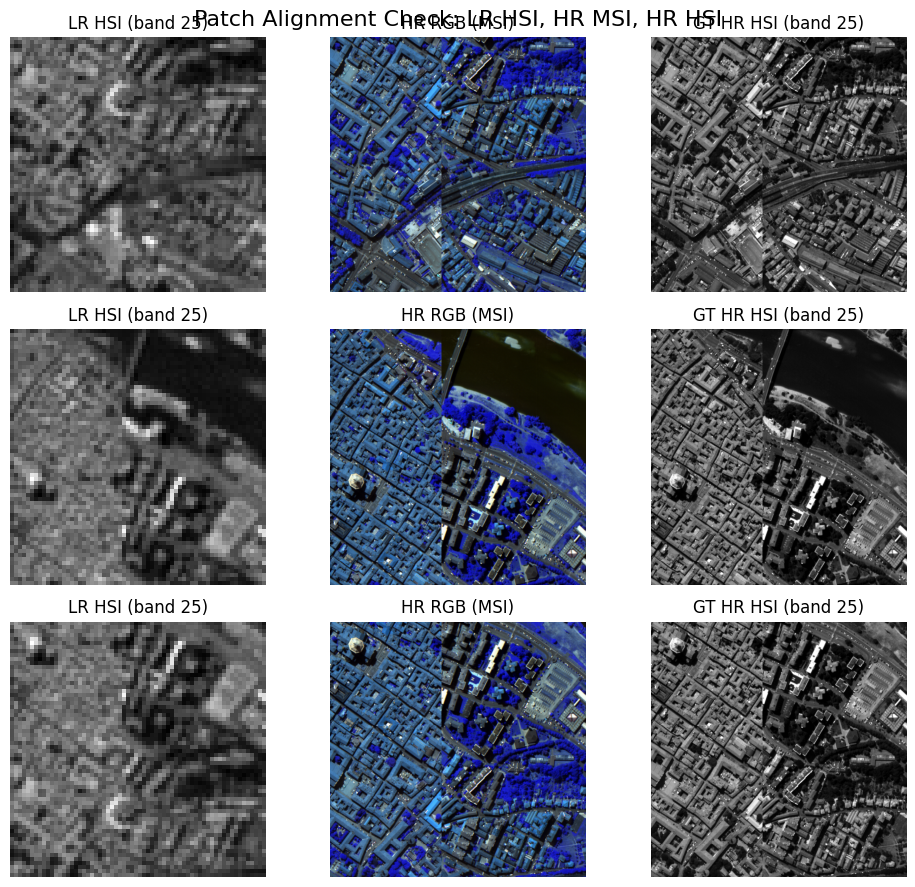

Training: 100%|██████████| 1000/1000 [09:38<00:00,  1.73epoch/s, avg_loss=1.5164e-01]


Training completed in  578.42 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1698198
FLOPs: 113674616832
Inference time: 0.0081 seconds
GPU memory consumed: 694.52 MB
SR image shape:  (512, 512, 50)
SR image max: 1.806299
SR image min: 0.0
SR image mean: 0.37763008
Saved the Super Resolved HSI 1 at location specified in uh_mimo_folder_path


In [22]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 50          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF,
    hr_msi  = I_MS_3,
    lr_hsi  = I_HS_8_gaus,
    patch_hr= 512,
    scale   = scale,
    stride_hr = 256)

print(msi_train.shape)
print(hsi_train.shape)
print(gt_train.shape)

plot_alignment_grid_np(hsi_train, msi_train, gt_train, band_lr=25, band_hr=25)

msi_test  = HR_MSI_test_1
hsi_test  = LR_HSI_test_1       

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = False)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
 
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1), dtype=torch.float32)[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1), dtype=torch.float32)[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image_1 = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

print("SR image shape: ", SR_image_1.shape)

print("SR image max:", SR_image_1.max())
print("SR image min:", SR_image_1.min())
print("SR image mean:", SR_image_1.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_mimo_folder_path}/UH_topleft.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_1)

print("Saved the Super Resolved HSI 1 at location specified in uh_mimo_folder_path")

In [23]:
visualize_hsi_single(SR_image_1, (20,13,8), "UH topleft SR")

In [24]:
patch = extract_patch_at_coordinates(SR_image_1, 125, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")

Super resolving UH image 2

In [25]:
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_test  = HR_MSI_test_2
hsi_test  = LR_HSI_test_2 

msi_t = torch.tensor(msi_test.transpose(2,0,1), dtype=torch.float32)[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1), dtype=torch.float32)[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image_2 = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

print("SR image shape: ", SR_image_2.shape)

print("SR image max:", SR_image_2.max())
print("SR image min:", SR_image_2.min())
print("SR image mean:", SR_image_2.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_mimo_folder_path}/UH_bottomright.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_2)

print("Saved Super Resolved HSI 2 at location specified in uh_mimo_folder_path")

Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1698198
FLOPs: 113674616832
Inference time: 0.0080 seconds
GPU memory consumed: 693.98 MB
SR image shape:  (512, 512, 50)
SR image max: 1.9076557
SR image min: 0.0
SR image mean: 0.4825196
Saved Super Resolved HSI 2 at location specified in uh_mimo_folder_path


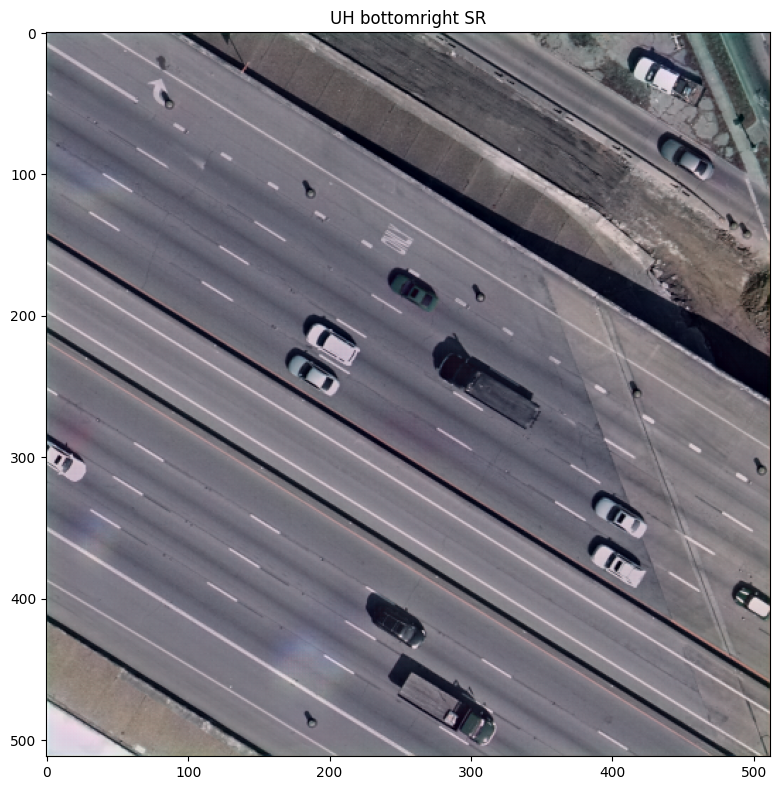

In [26]:
visualize_hsi_single(SR_image_2, (20,13,8), "UH bottomright SR")

In [27]:
patch = extract_patch_at_coordinates(SR_image_2, 300, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")